In [149]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
from statsmodels import stats as sms
from ydata_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("pastel") 

# 1. Загрузка и обработка данных

In [150]:
data = pd.read_csv('data/ds_salaries.csv')
data.head(1)

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L


In [151]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


### 1.1 Формирование отчета

Для рассмотрения общей структуры и первичной оценке данных, сформируем отчет

In [152]:
# Отчет уже сформирован.
# Если возникла необходимость пересоздать(проверить), просто раскомментируйте и запустите
# profile = ProfileReport(data)
# profile.to_file('./data/DS_salary_analyze_before.html')

Рассмотрим корреляционную матрицу:  
![Корреляционная матрица данных по зарплатам](./data/corr_heatmap.jpg)

Поиск несбалансированных переменных:
* В нашем случае, если больше 90% занимает одна переменная

In [153]:
# Отбор категорий, в которых больше чем 90% занимает одна величина
high_freq_categories = []
for column in data.columns:
    freqency = data[column].value_counts(normalize=True)
    if not freqency[freqency > 0.9].empty:
        high_freq_categories.append(column)

display(high_freq_categories)

['employment_type']

При рассмотрении корреляционной матрицы и первичном анализе параметров, иммет смысл удалить следующие:
* Unnamed: 0 - Безсмысленный параметр, повторяющий индексацию;
* salary - В данных есть параметр, обозначающий зарплату в USD - salary_to_usd, следовательно, этот параметр больше неинформативен;
* salary_currency - Если удаляем зарплату в валюте, то валюта нам больше не нужна по определению;
* company_location - параметр с мультиколлинеарностью
* employment_type - ~97% значений занимает один тип (FT), остальные 3 значения ~1%.

### 1.2 Удаление неинформативных признаков

In [154]:
data = data.drop(['Unnamed: 0', 'salary', 'salary_currency', 'company_location', 'employment_type'], axis=1)

### 1.3 Поиск дубликатов и нулевых значений

In [155]:
# Удаление дубликотов
data = data.drop_duplicates()
# Определение количества нулевых значений в каждом параметре
data.isna().sum()

work_year             0
experience_level      0
job_title             0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_size          0
dtype: int64

### 1.4 Классификация и преобразование признаков

В данных все признаки являются категориальными, кроме:
* salary_in_usd - заработная плата в USD

Несмотря на то, что значения признака *remote_ratio* предсавлены числами, он является **категориальным**. Это связано с тем, что данный признак принимает значения-ярлыки, которые просто представляют разные уровни удаленной работы.  
Тоже самое можно сказать признак *work_year* - он является **категориальным**. Потому что мы рассматриваем не временной промежутоки тенденции изменения от года к году, а просто 3 группы работников, которые получали зарплату за определенный год (2020, 2021, 2022)


Перевод числовыъ признаков в категориальные

In [156]:
data['remote_ratio'] = data['remote_ratio'].astype('object')
data['work_year'] = data['work_year'].astype('object')

Преобразвание 

In [157]:
def frequency_adjustment(data: pd.DataFrame, num_significant: int, *features: str) -> pd.DataFrame:
    """
    Оставляет num_significant элементов в feature без изменений, остальные группируются в 'other'

    Args:
        data (pd.DataFrame): Изначальный DataFrame;
        num_significant (int): количество значимых элементов, которые остануться без изменения;
        *features - признаки, которые надо преобразовать.
    
    Returns:
        pd.DataFrame: DataFrame после преобразования
            Преобразует DataGrame по определенному признаку следующим образом:
    
    Пример вызова:
        data = frequency_adjustment(data, 10, 'job_title', 'employee_residence')
    """
    
    
    # Copy data to return it if have an Error
    data_without_changes = data.copy()
    
    for feature in features:
        # If feature does not exist
        try:
            frequency_feature = data[feature].value_counts().nlargest(num_significant).index.to_list()
            data[feature] = data[feature].apply(lambda x: x if x in frequency_feature else 'other')
        except KeyError:
            print(f'Feature {feature} is not exist!')
            return data_without_changes

    return data

data = frequency_adjustment(data, 5, 'job_title', 'employee_residence')

### 1.5 Определение основных статистических характеристик

In [158]:
data.describe(include='all')

,work_year,experience_level,job_title,salary_in_usd,employee_residence,remote_ratio,company_size
count,565.0,565,565,565.000000,565,565.0,565
unique,3.0,4,6,NaN,6,3.0,3
top,2022.0,SE,other,NaN,US,100.0,M
freq,278.0,243,177,NaN,295,346.0,290
mean,NaN,NaN,NaN,110610.343363,NaN,NaN,NaN
std,NaN,NaN,NaN,72280.702792,NaN,NaN,NaN
min,NaN,NaN,NaN,2859.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,60757.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,100000.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,150000.000000,NaN,NaN,NaN


In [159]:
# profile = ProfileReport(data)
# profile.to_file('./data/DS_salary_analyze_after.html')

# 2. Разведываетльный анализ данных

### Базовый анализ для каждого признака

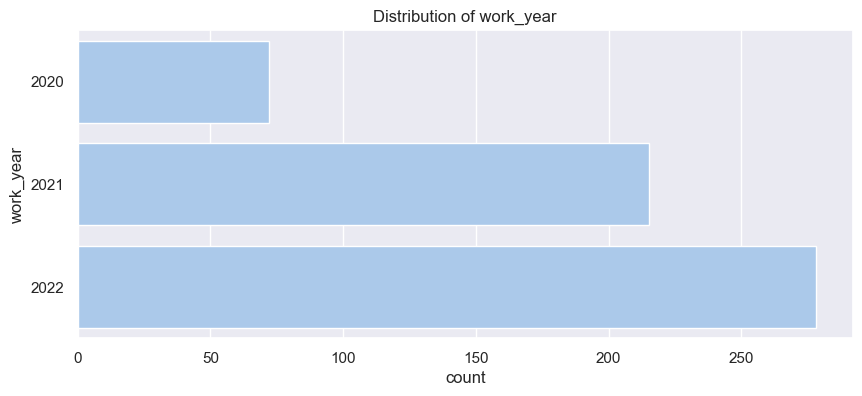

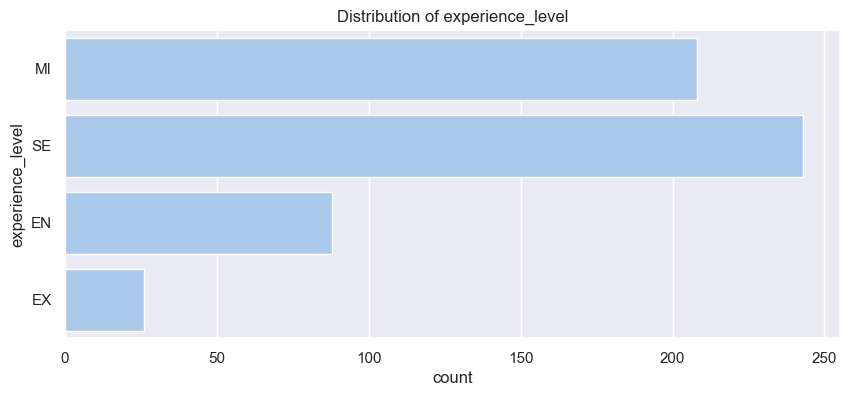

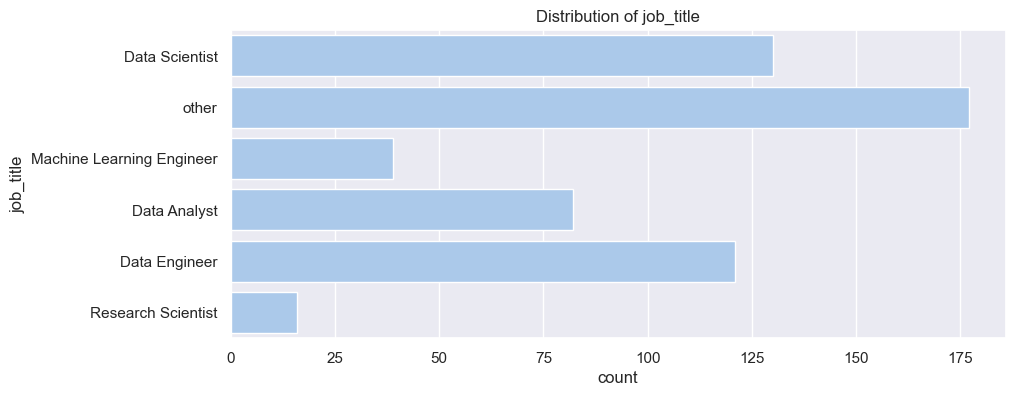

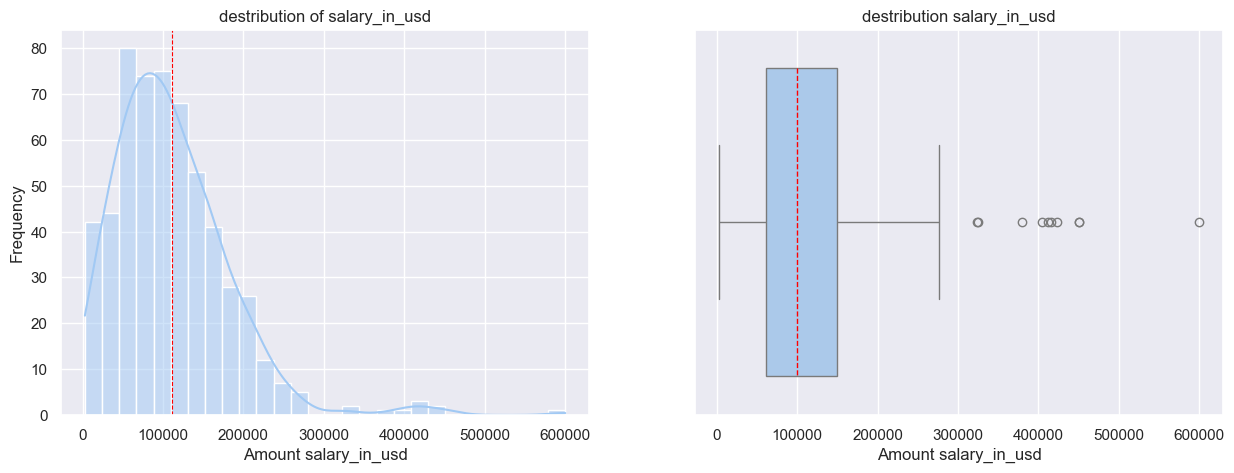

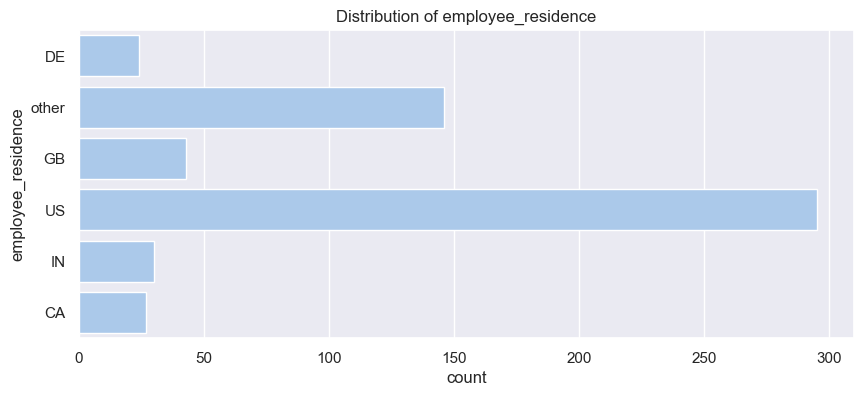

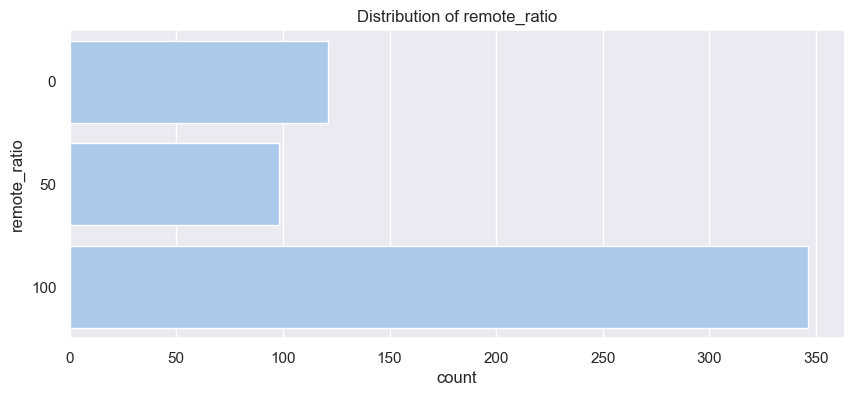

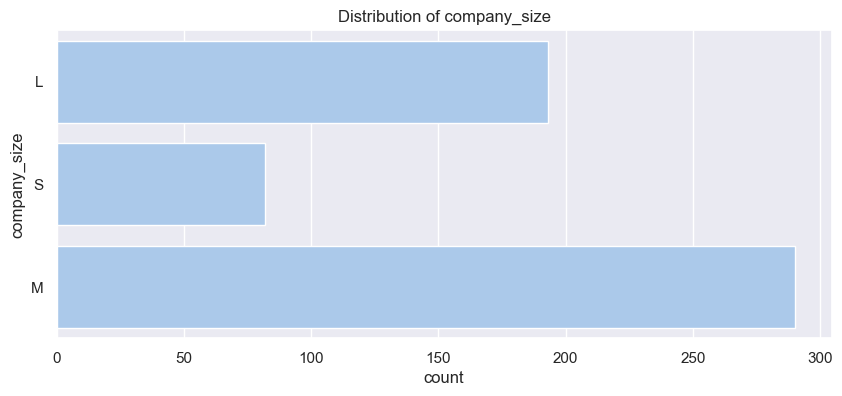

In [160]:
# Построение графиков для всех признаков, участвующих в анализе
for column in data.columns:
    # Если признак численный - histogram и boxplot
    if data[column].dtype == 'int64':
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        sns.histplot(data[column], kde=True, ax=axes[0])
        axes[0].set(xlabel=f'Amount {column}', ylabel='Frequency')
        axes[0].set_title(f'destribution of {column}')
        axes[0].axvline(data[column].mean(), color='red', linestyle='--', linewidth=0.8)

        sns.boxplot(data[column], ax=axes[1], orient='h', medianprops={'color': 'red', 'linestyle': '--'})
        axes[1].set(xlabel=f'Amount {column}')
        axes[1].set_title(f'destribution {column}')

        plt.show()
    # Если признак категориальный - countplot
    else:
        plt.figure(figsize=(10, 4))
        sns.countplot(y=column, data=data)
        plt.title(f'Distribution of {column}')
        plt.show()

Распределение заработных плат отлично от нормального, имеются выбросы

## 3.Графические исследования данных, с подерплением рузельтатов с помощью статистических тестов

In [161]:
# Задание уровня значимости
alpha = 0.05

# функция для принятия решения о нормальности
def decision_normality(p):
    print(f'p-value = {round(p, 3)}')
    if p <= alpha:
        print(f'p-значение меньше, чем заданный уровень значимости {alpha}. Распределение отлично от нормального')
    else:
        print(f'p-значение больше, чем заданный уровень значимости {alpha}. Распределение является нормальным')


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print(f'p-value = {round(p, 3)}')
    if p <= alpha:
        print(f'p-значение меньше, чем заданный уровень значимости {alpha}. Отвергаем нулевую гипотезу в пользу альтернативной.')
    else:
        print(f'p-значение больше, чем заданный уровень значимости {alpha}. У нас нет оснований отвергнуть нулевую гипотезу.')
   

### 3.1. Зависит ли размер Заработной платы от года выплаты?

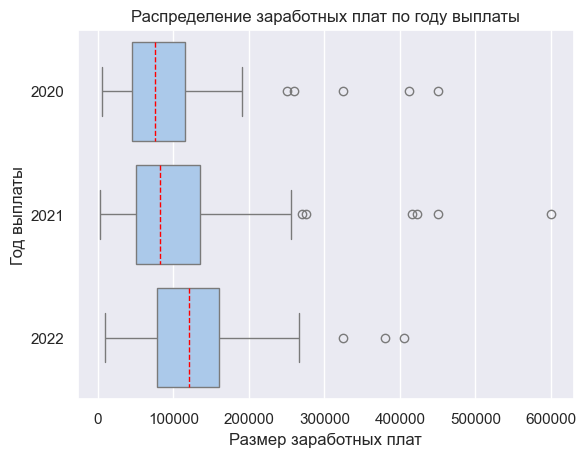

In [162]:
ax = sns.boxplot(data, x='salary_in_usd', y='work_year', orient='h', medianprops={'color': 'red', 'linestyle': '--'})
ax.set(xlabel='Размер заработных плат', ylabel='Год выплаты')
plt.title('Распределение заработных плат по году выплаты')
plt.show()

In [163]:
data_agg = data.groupby('work_year')['salary_in_usd'].describe().round(2)
data_agg

,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,72.0,95813.00,82831.80,5707.0,45724.5,75544.0,115526.0,450000.0
2021,215.0,99430.41,80304.32,2859.0,50000.0,82528.0,135000.0,600000.0
2022,278.0,123089.10,59888.93,10000.0,78791.0,120000.0,160000.0,405000.0


На первый взляд в 2022 году набюдается рост средней заработной платы примерно на 30%, по-моему мнению, данные различия статистически значимы, данную гипотезу проверим, проведя статистическое тестирование

##### Сформулируем нулевую и альтернативные гипотезы  
Нулевая гипотеза: размер заработной платы не отличается в зависимости от года выплаты: 2020 год ($\mu_1$), 2021 год ($\mu_2$), 2022 год ($\mu_3$). $$H_0:\mu_1 = \mu_2 = \mu_3$$
Альтернативная гипотеза: размер заработной платы отличается в зависимости от года выплаты: 2020 год ($\mu_1$), 2021 год ($\mu_2$), 2022 год ($\mu_3$). $$H_1:\mu_1 \neq \mu_2 \neq \mu_3$$
**Проверка на нормальность**:  
С помощью теста Шапира-Уилка проверим, распределен ли признак нормально.

In [164]:
salary_2020 = data.loc[data['work_year']==2020, 'salary_in_usd']
salary_2021 = data.loc[data['work_year']==2021, 'salary_in_usd']
salary_2022 = data.loc[data['work_year']==2022, 'salary_in_usd']

print('Для 2020 года:')
_, p = stats.shapiro(salary_2020)
decision_normality(p)

print('Для 2020 года:')
_, p = stats.shapiro(salary_2021)
decision_normality(p)

print('Для 2022 года:')
_, p = stats.shapiro(salary_2022)
decision_normality(p)

Для 2020 года:
p-value = 0.0
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2020 года:
p-value = 0.0
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2022 года:
p-value = 0.0
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**  
* Признак "Заработная плата" - Числовой;
* Сравниваемых групп - 3;
* Группы *не зависимы*
* Признак распределен *не по нормальному* закону
Для проверки гипотезы используем критерий **Краскеса-Уолиса**

In [165]:
_, p = stats.kruskal(salary_2020, salary_2021, salary_2022)
decision_hypothesis(p)

p-value = 0.0
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**  
Как и предполагалось, заработная плата зависит от года выплаты. То есть в 2020, 2021, 2022 году ЗП неодинаковы

### 3.2 Зависимы ли уровни ЗП от Уровня опыта

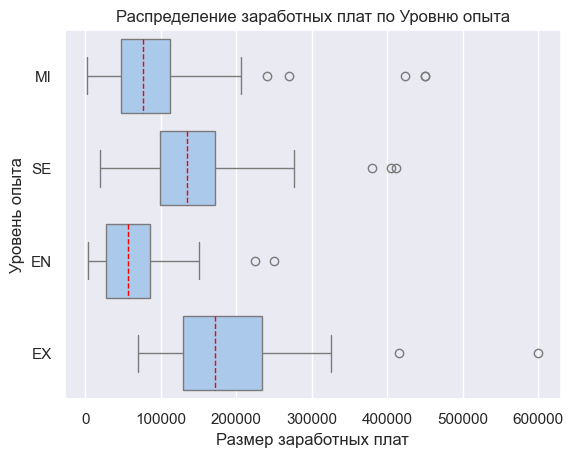

In [166]:
ax = sns.boxplot(data, x='salary_in_usd', y='experience_level', orient='h', medianprops={'color': 'red', 'linestyle': '--'})
ax.set(xlabel='Размер заработных плат', ylabel='Уровень опыта')
plt.title('Распределение заработных плат по Уровню опыта')
plt.show()

In [167]:
data_agg = data.groupby('experience_level')['salary_in_usd'].describe().round(2)
data_agg

,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,88.0,61643.32,44395.54,4000.0,27505.00,56500.0,85425.75,250000.0
EX,26.0,199392.04,117071.26,69741.0,130006.50,171437.5,233750.00,600000.0
MI,208.0,87793.00,64118.97,2859.0,47163.75,76940.0,112075.00,450000.0
SE,243.0,138374.88,59955.97,18907.0,99531.50,135000.0,171881.00,412000.0


Уровень заработной платы зависит от опыта работы, и эта зависимость, на первый взгляд, статистически значимая.  
Самый высокий уровень - у руководителей, дальше - Старшие специалисты, средние и младшие.  
По логике вещей, так и должно быть.

##### Сформулируем нулевую и альтернативные гипотезы  
Нулевая гипотеза: размер заработной платы не отличается в зависимости от уровня специалиста: Junior ($\mu_1$), Middle ($\mu_2$), Senior ($\mu_3$), Director ($\mu_4$). $$H_0:\mu_1 = \mu_2 = \mu_3 = \mu_4$$
Альтернативная гипотеза: размер заработной платы отличается в зависимости от уровня специалиста: Junior ($\mu_1$), Middle ($\mu_2$), Senior ($\mu_3$), Director ($\mu_4$). $$H_1:\mu_1 \neq \mu_2 \neq \mu_3 \neq \mu_4$$
**Проверка на нормальность**:  
С помощью теста Шапира-Уилка проверим, распределен ли признак нормально.

In [168]:
exp_en = data.loc[data['experience_level']=='EN', 'salary_in_usd']
exp_ex = data.loc[data['experience_level']=='EX', 'salary_in_usd']
exp_mi = data.loc[data['experience_level']=='MI', 'salary_in_usd']
exp_se = data.loc[data['experience_level']=='SE', 'salary_in_usd']

print('Для Junior:')
_, p = stats.shapiro(exp_en)
decision_normality(p)

print('Для Middle:')
_, p = stats.shapiro(exp_mi)
decision_normality(p)

print('Для Senior:')
_, p = stats.shapiro(exp_se)
decision_normality(p)

print('Для Director:')
_, p = stats.shapiro(exp_ex)
decision_normality(p)

Для Junior:
p-value = 0.0
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для Middle:
p-value = 0.0
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для Senior:
p-value = 0.0
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для Director:
p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**  
* Признак "Заработная плата" - Числовой;
* Сравниваемых групп - 4;
* Группы *не зависимы*
* Признак распределен *не по нормальному* закону
Для проверки гипотезы используем критерий **Краскеса-Уолиса**

In [169]:
_, p = stats.kruskal(exp_en, exp_ex, exp_mi, exp_se)

decision_hypothesis(p)

p-value = 0.0
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**  
Уровень заработной платы зависит от уровня специалиста

### 3.3 Больше ли зарплата у Data Science специалистов, чем у Data Engineer специалистов?

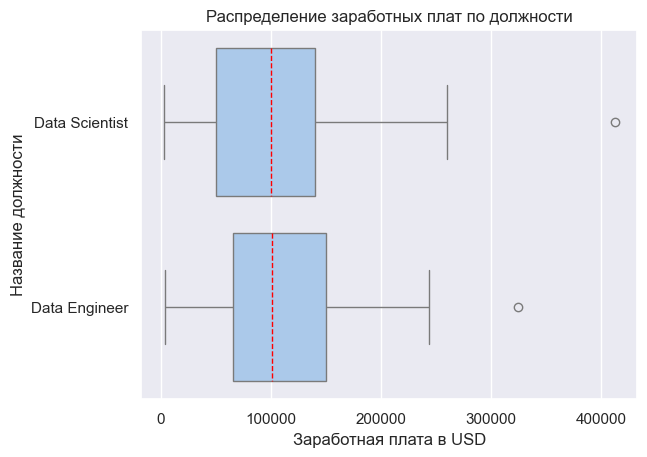

In [202]:

DS_filtered_data = data[data['job_title'].isin(['Data Scientist', 'Data Engineer'])]
ax = sns.boxplot(DS_filtered_data, x='salary_in_usd', y='job_title', orient='h', medianprops={'color': 'red', 'linestyle':'--'})
ax.set_title('Распределение заработных плат по должности')
ax.set(xlabel='Заработная плата в USD', ylabel='Название должности')
plt.show()

In [171]:
data_agg = DS_filtered_data.groupby('job_title')['salary_in_usd'].describe().round(2)
data_agg

,count,mean,std,min,25%,50%,75%,max
job_title,,,,,,,,
Data Engineer,121.0,109750.03,58203.68,4000.0,66022.00,100800.0,150000.0,324000.0
Data Scientist,130.0,103336.35,63967.56,2859.0,50330.25,100000.0,140400.0,412000.0


Медианы практически одинаковые, на первый взгляд отличий практически нет, либо они не статистически значимые.

#### Сформулируем нулевую и альтернативные гипотезы  
Нулевая гипотеза: размер заработной у Data Science специалистов ($\mu_1$) статистически меньше или равно заработной плате у Data Engineer специалистов($\mu_2$). $$H_0:\mu_1 <= \mu_2$$
Альтернативная гипотеза: размер заработной у Data Science специалистов ($\mu_1$) статистически больше заработной платы у Data Engineer специалистов($\mu_2$). $$H_1:\mu_1 > \mu_2$$
**Проверка на нормальность**:  
С помощью теста Шапира-Уилка проверим, распределен ли признак нормально.

In [172]:
ds_sal = DS_filtered_data.loc[DS_filtered_data['job_title'] == 'Data Scientist', 'salary_in_usd']
de_sal = DS_filtered_data.loc[DS_filtered_data['job_title'] == 'Data Engineer', 'salary_in_usd']

_, p = stats.shapiro(ds_sal)
print('ЗП для DS:')
decision_normality(p)

_, p = stats.shapiro(de_sal)
print('ЗП для DE:')
decision_normality(p)

ЗП для DS:
p-value = 0.0
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
ЗП для DE:
p-value = 0.004
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**  
* Признак "Заработная плата" - Числовой;
* Сравниваемых групп - 2;
* Группы *не зависимы*
* Признак распределен *не по нормальному* закону
Для проверки гипотезы используем **U-критерий Манна-Уитни**

In [173]:
_, p = stats.mannwhitneyu(ds_sal, de_sal, alternative='greater')
decision_hypothesis(p)


p-value = 0.837
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**  
Нет оснований отвегнуть нулевую гипотезу, следовательно, ЗП у Data Science специалистов <= ЗП у Data Engineer специалистов

### 3.4 Зависит уровень ЗП от страны проживания сотрудника?

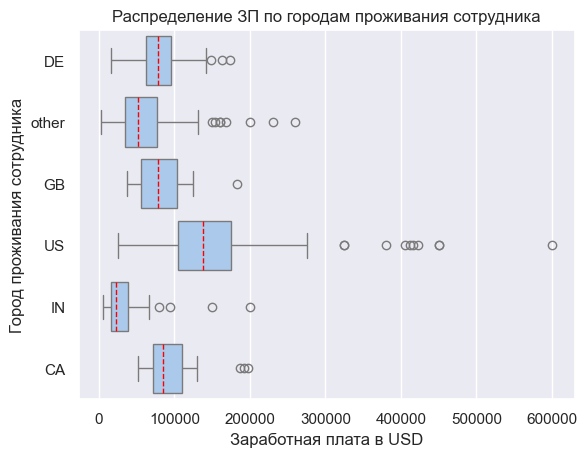

In [201]:
ax = sns.boxplot(data, x='salary_in_usd', y='employee_residence', orient='h', medianprops={'color': 'red', 'linestyle': '--'})
ax.set_title('Распределение ЗП по городам проживания сотрудника')
ax.set(xlabel='Заработная плата в USD', ylabel='Город проживания сотрудника')
plt.show()

 Из графика распределения видно, что средняя ЗП зависит от места работы(проживания) специалиста, так самый маленький межквартильный размах и среднее - у Индийский специалистов, обратная же ситуация - у Американцев.

### Соответствует ли средняя заработная плата у сотрудников, не работающих удаленно 100000 USD?

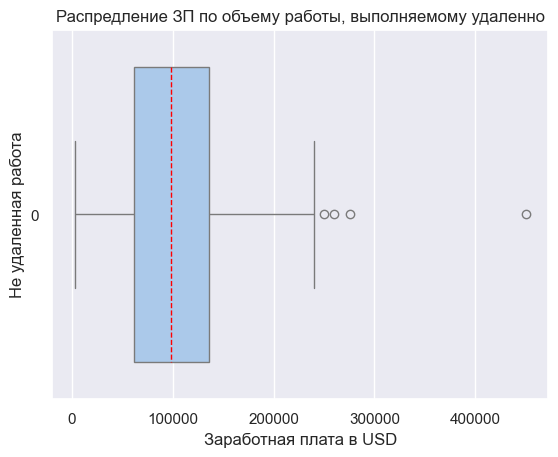

In [200]:
data_no_remote_ratio = data[data['remote_ratio'] == 0]
ax = sns.boxplot(data_no_remote_ratio, x='salary_in_usd', y='remote_ratio', 
                 orient='h', medianprops={'color': 'red', 'linestyle': '--'})
ax.set(xlabel='Заработная плата в USD', ylabel='Не удаленная работа')
ax.set_title('Распредление ЗП по объему работы, выполняемому удаленно')
plt.show()

##### Сформулируем нулевую и альтернативные гипотезы  
Нулевая гипотеза: размер средней заработной платы у сотрудников, не работающих удаленно ($\mu_1$) равно 100000. $$H_0:\mu_1 = 100000$$
Альтернативная гипотеза: размер средней заработной платы у сотрудников, не работающих удаленно ($\mu_1$) не соответсвует 100000. $$H_1:\mu_1 \neq 100000$$
**Проверка на нормальность**:  
С помощью теста Шапира-Уилка проверим, распределен ли признак нормально.

In [176]:
salary_no_remote_ratio = data_no_remote_ratio['salary_in_usd']
_, p = stats.shapiro(salary_no_remote_ratio)

decision_normality(p)

p-value = 0.0
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**  
* Признак "Заработная плата" - Числовой;
* Сравниваемых групп - 1;
* Признак распределен *не по нормальному* закону
Для проверки гипотезы используем **Критерий знаков одной выборки**

In [177]:
_, p = sms.descriptivestats.sign_test(salary_no_remote_ratio, 100000)

decision_hypothesis(p)

p-value = 0.582
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**  
Медиана зарплат не отличается от 100000 на статистически значимом уровне.

### 3.5 Размер средней заработной платы в большой компании больше, чем в средней?

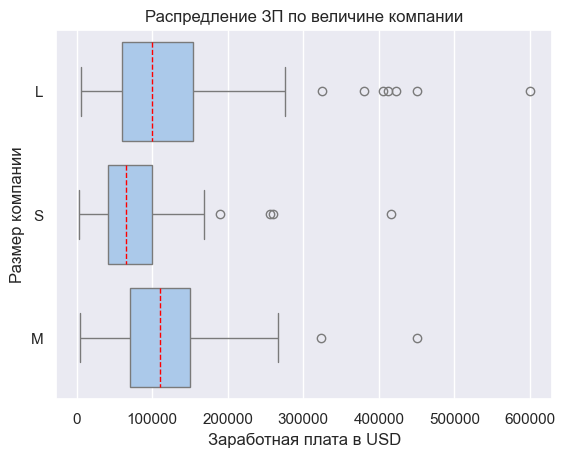

In [199]:
ax = sns.boxplot(data, x='salary_in_usd', y='company_size', orient='h', medianprops={'color': 'red', 'linestyle': '--'})
ax.set_title('Распредление ЗП по величине компании')
ax.set(xlabel='Заработная плата в USD', ylabel='Размер компании')
plt.show()

##### Сформулируем нулевую и альтернативные гипотезы  
Нулевая гипотеза: размер средней заработной платы в больших компаниях ($\mu_1$) статистически меньше или равно заработной плате в средних компаниях($\mu_2$). $$H_0:\mu_1 <= \mu_2$$
Альтернативная гипотеза: размер средней заработной платы в больших компаниях ($\mu_1$) статистически больше заработной платы в средних компаниях($\mu_2$). $$H_1:\mu_1 > \mu_2$$
**Проверка на нормальность**:  
С помощью теста Шапира-Уилка проверим, распределен ли признак нормально.

In [179]:
salary_medium_comp = data[data['company_size'] == 'M']['salary_in_usd']
salary_large_comp = data[data['company_size'] == 'L']['salary_in_usd']

_, p = stats.shapiro(salary_medium_comp)
print('Для средних компний:')
decision_normality(p)

_, p = stats.shapiro(salary_large_comp)
print('Для больших компний:')
decision_normality(p)

Для средних компний:
p-value = 0.0
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для больших компний:
p-value = 0.0
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**  
* Признак "Заработная плата" - Числовой;
* Сравниваемых групп - 2;
* Группы *не зависимы*
* Признак распределен *не по нормальному* закону
Для проверки гипотезы используем **U-критерий Манна-Уитни**

In [180]:
_, p = stats.mannwhitneyu(salary_large_comp, salary_medium_comp, alternative='greater')
decision_hypothesis(p)


p-value = 0.842
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**  
Зарплата в больших компаниях не больше, чем в средних

In [181]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 565 entries, 0 to 606
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           565 non-null    object
 1   experience_level    565 non-null    object
 2   job_title           565 non-null    object
 3   salary_in_usd       565 non-null    int64 
 4   employee_residence  565 non-null    object
 5   remote_ratio        565 non-null    object
 6   company_size        565 non-null    object
dtypes: int64(1), object(6)
memory usage: 35.3+ KB


### 3.6 Существует ли связь между удаленной работой и размером компании?

**Подбор подходящего статистического теста**  
* Критерии - категориальные;  
Следовательно, используем **Критерий $\chi^2$**

Нулевая гипотеза ($H_0$): Признаки независимы (нет связи между удалённостью работы и размером компании).  
Альтернативная гипотеза ($H_1$): Признаки зависимы (существует связь между удалённостью работы и размером компании).

In [182]:
contingency_table = pd.crosstab(data['remote_ratio'], data['company_size'])

# Применяем хи-квадрат тест
_, p, _, _ = stats.chi2_contingency(contingency_table)
decision_hypothesis(p)

p-value = 0.0
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**  
Признаки зависимы (существует связь между удалённостью работы и размером компании)

# 4. Ответ на бизнес-вопросы

### 4.1 Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

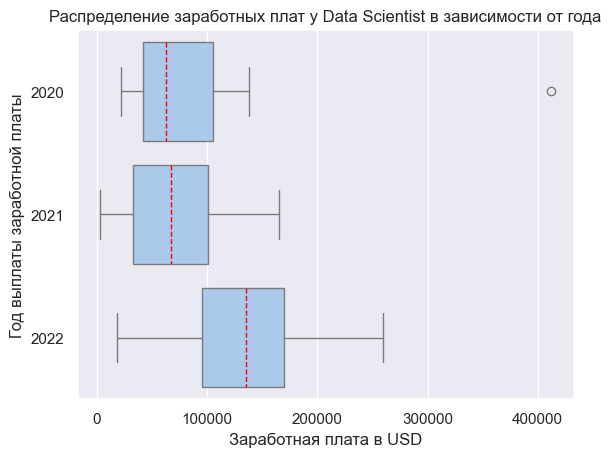

In [198]:
# Отбор только тех ячеек, в которых вакансия - Data Scientist
data_scientist = data[data['job_title'] == 'Data Scientist']

ax = sns.boxplot(data_scientist, x='salary_in_usd', y='work_year', orient='h', medianprops={'color': 'red', 'linestyle': '--'})
ax.set_title('Распределение заработных плат у Data Scientist в зависимости от года')
ax.set(xlabel='Заработная плата в USD', ylabel='Год выплаты заработной платы')
plt.show()

Из графика можно сделать очевидный вывод, что в 2022 году было серьезное повышение ЗП, однако, осталось определить, является ли статистически значимым повышение в 2021 в сравнении с 2020?

##### Сформулируем нулевую и альтернативные гипотезы  
Нулевая гипотеза: размер средней заработной платы для Data Scientist в 2021 году ($\mu_1$) статистически меньше или равно заработной плате для Data Scientist в 2020 ($\mu_2$). $$H_0:\mu_1 <= \mu_2$$
Альтернативная гипотеза: размер средней заработной платы для Data Scientist в 2021 году ($\mu_1$) статистически больше или равно заработной плате для Data Scientist в 2020 ($\mu_2$). $$H_1:\mu_1 > \mu_2$$
**Проверка на нормальность**:  
С помощью теста Шапира-Уилка проверим, распределен ли признак нормально.

In [184]:
salary_2021 = data_scientist[data_scientist['work_year'] == 2021]['salary_in_usd']
salary_2020 = data_scientist[data_scientist['work_year'] == 2020]['salary_in_usd']

_, p = stats.shapiro(salary_2021)
print('Для Зарплат в 2021 году:')
decision_normality(p)

_, p = stats.shapiro(salary_2020)
print('Для Зарплат в 2020 году:')
decision_normality(p)


Для Зарплат в 2021 году:
p-value = 0.107
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для Зарплат в 2020 году:
p-value = 0.0
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**  
* Признак "Заработная плата" - Числовой;
* Сравниваемых групп - 2;
* Группы *не зависимы*
* Один признак распределен по нормальному закону, второй - нет
Для проверки гипотезы используем **U-критерий Манна-Уитни**  
Так как это тест, который не предполагает нормальности данных.

In [185]:
_, p = stats.mannwhitneyu(salary_2021, salary_2020, alternative='greater')

decision_hypothesis(p)

p-value = 0.705
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**  
Для профессии Data Scientist, на основании результатов статистического теста, не наблюдался рост заработных плат с 2020 по 2021 год, тогда как в 2022 произошел резкий скачок.  

### 4.2 Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

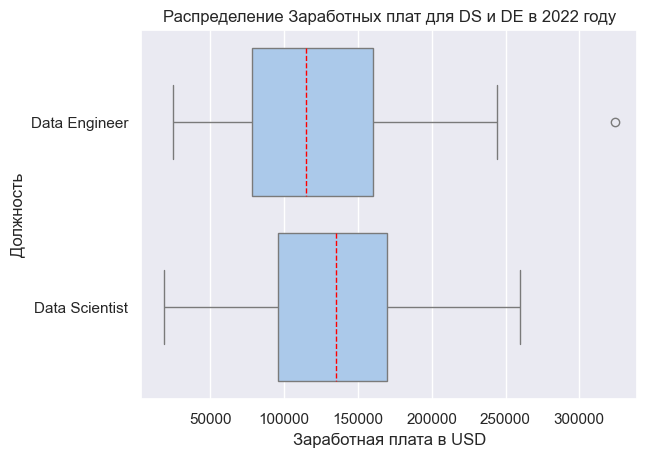

In [197]:
# Определение данных только для Data Scintist или Data Engineer
ds_de_data = data[(data['job_title'] == 'Data Scientist') | (data['job_title'] == 'Data Engineer')]
# Фильтрация данных зарплат только за 2022 год
ds_de_data_2022 = ds_de_data[ds_de_data['work_year'] == 2022]

ax = sns.boxplot(ds_de_data_2022, x='salary_in_usd', y='job_title', orient='h', medianprops={'color': 'red', 'linestyle': '--'})
ax.set_title('Распределение Заработных плат для DS и DE в 2022 году')
ax.set(xlabel='Заработная плата в USD', ylabel='Должность')
plt.show()

##### Сформулируем нулевую и альтернативные гипотезы  
Нулевая гипотеза: размер средней заработной платы для Data Scientist в 2022 году ($\mu_1$) статистически не отличается от заработной платы для Data Engineer в 2022 ($\mu_2$). $$H_0:\mu_1 = \mu_2$$
Альтернативная гипотеза: размер средней заработной платы для Data Scientist в 2022 году ($\mu_1$) статистически отличается от заработной платы для Data Engineer в 2022 ($\mu_2$). $$H_1:\mu_1 \neq \mu_2$$
**Проверка на нормальность**:  
С помощью теста Шапира-Уилка проверим, распределен ли признак нормально.

In [191]:
# Проврка на нормальность распределений
salary_ds_2022 = ds_de_data_2022[ds_de_data_2022['job_title'] == 'Data Scientist']['salary_in_usd']
salary_de_2022 = ds_de_data_2022[ds_de_data_2022['job_title'] == 'Data Engineer']['salary_in_usd']

_, p = stats.shapiro(salary_ds_2022)
print('Зарплата для Data Scientist в 2022 году:')
decision_normality(p)

_, p = stats.shapiro(salary_de_2022)
print('Зарплата для Data Engineer в 2022 году:')
decision_normality(p)

Зарплата для Data Scientist в 2022 году:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Зарплата для Data Engineer в 2022 году:
p-value = 0.007
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**  
* Признак "Заработная плата" - Числовой;
* Сравниваемых групп - 2;
* Группы *не зависимы*
* Один признак распределен по нормальному закону, второй - нет
Для проверки гипотезы используем **U-критерий Манна-Уитни**  
Так как это тест, который не предполагает нормальности данных.

In [135]:
# Проведение статистического теста и вывод
_, p = stats.mannwhitneyu(salary_ds_2022, salary_de_2022, alternative='two-sided')

decision_hypothesis(p)

p-value = 0.319
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**  
Нет оснований считать, что зарплаты в этих двух группах различаются.

### 4.3. Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров

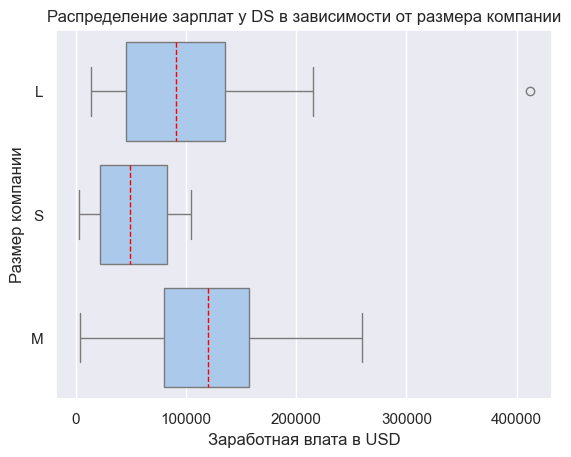

In [194]:
ax = sns.boxplot(data_scientist, x='salary_in_usd', y='company_size', medianprops={'color': 'red', 'linestyle': '--'})
ax.set_title('Распределение зарплат у DS в зависимости от размера компании')
ax.set(xlabel='Заработная влата в USD', ylabel='Размер компании')
plt.show()

##### Сформулируем нулевую и альтернативные гипотезы  
Нулевая гипотеза: размер средней заработной платы для Data Scientist в маленькой компании ($\mu_1$), средней компании ($\mu_2$) и большой компании ($\mu_3$) статистически значимых различий не имеют. $$H_0:\mu_1 = \mu_2 = \mu_3$$
Альтернативная гипотеза: размер средней заработной платы для Data Scientist в маленькой компании ($\mu_1$), средней компании ($\mu_2$) и большой компании ($\mu_3$) имеют статистически значимые различия. $$H_1:\mu_1 \neq \mu_2 \neq \mu_3$$
**Проверка на нормальность**:  
С помощью теста Шапира-Уилка проверим, распределен ли признак нормально.

In [142]:
# Определение ЗП для DS в компаниях с разным размером
salary_ds_S = data_scientist[data_scientist['company_size'] == 'S']['salary_in_usd']
salary_ds_M = data_scientist[data_scientist['company_size'] == 'M']['salary_in_usd']
salary_ds_L = data_scientist[data_scientist['company_size'] == 'L']['salary_in_usd']

# Определение нормальности распределения данных
_, p = stats.shapiro(salary_ds_S)
print('Зарплата для DS в маленьких компаниях:')
decision_normality(p)
print('--------------------')

_, p = stats.shapiro(salary_ds_M)
print('Зарплата для DS в средних компаниях:')
decision_normality(p)
print('--------------------')

_, p = stats.shapiro(salary_ds_L)
print('Зарплата для DS в больших компаниях:')
decision_normality(p)
print('--------------------')

_, p = stats.levene(salary_ds_S, salary_ds_M, salary_ds_L)
print(f'p_value_levene = {round(p, 3)}')
if p <= alpha:
    print('В группах есть статистически значимые отличия в дисперсиях')
else:
    print('В группах нет статистически значимые отличия в дисперсиях')


Зарплата для DS в маленьких компаниях:
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
--------------------
Зарплата для DS в средних компаниях:
p-value = 0.897
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
--------------------
Зарплата для DS в больших компаниях:
p-value = 0.0
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
--------------------
p_value_levene = 0.043
В группах есть статистически значимые отличия в дисперсиях


Из выше приведенных результатов делаем вывод, что тест ANOVA нам не подходит, следовательно, будем использовать **Критерий Краскела-Уоллиса**

In [143]:
_, p = stats.kruskal(salary_ds_S, salary_ds_M, salary_ds_L)

decision_hypothesis(p)

p-value = 0.0
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Так как результаты имеют значимые отличия, определим, какие из групп.  
Для этого проведем тетсирование **критерием Манна-Уитни** для парного сравнения каждого из параметров и сделаем выводы.

In [147]:
# H0: S <= M
# H1: S > M
_, p_s_m = stats.mannwhitneyu(salary_ds_S, salary_ds_M, alternative='greater')
# H0: S <= L
# H1: S > L
_, p_s_l = stats.mannwhitneyu(salary_ds_S, salary_ds_L, alternative='greater')
# H0: M <= L
# H1: M > L
_, p_m_l = stats.mannwhitneyu(salary_ds_M, salary_ds_L, alternative='greater')

print('S vs M:')
decision_hypothesis(p_s_m)
print('------------------')


print('S vs L:')
decision_hypothesis(p_s_l)
print('------------------')

print('M vs L:')
decision_hypothesis(p_m_l)
print('------------------')


S vs M:
p-value = 1.0
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.
------------------
S vs L:
p-value = 0.999
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.
------------------
M vs L:
p-value = 0.024
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
------------------


**Вывод**  
Каждый из типов имеет статистически значимое отличие от другой группы (из результатов критерия Краскела-Уоллиса).  
Соотношение заработных плат DS от размера компании определяется следующим соотношением (из результатов критерия Манна-Уитни):$$M > L > S$$



### 4.4 Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

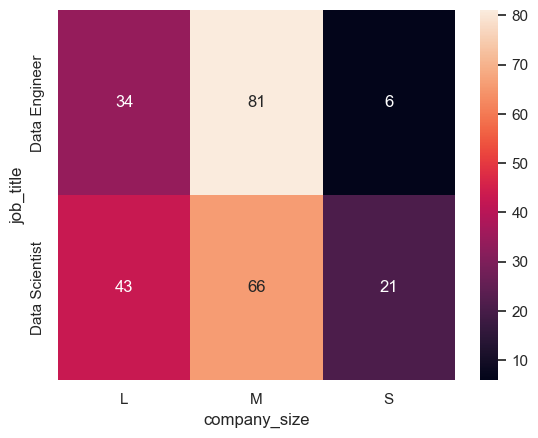

In [193]:
crosstab = pd.crosstab(index=ds_de_data['job_title'], columns=ds_de_data['company_size'])
ax = sns.heatmap(crosstab, annot=True)